# 05 - Pix2Pix Inference

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from botocore.exceptions import ClientError
import boto3
import io
from itertools import product
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tifffile as tif
from tqdm import tqdm

import torch
import torch.nn as nn

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_rows', None)

/Users/loaner/.pyenv/versions/3.8.15/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_STATE=42

### Create train, validation, test splits

In [3]:
%cd ~/projects/dd-biomassters
df_metadata = pd.read_csv("data/metadata/features_metadata.csv",index_col=0)
all_chips = list(df_metadata.chip_id.unique())
train_chips = list(df_metadata[df_metadata.split=='train'].chip_id.unique())
test_chips = list(df_metadata[df_metadata.split=='test'].chip_id.unique())

df_metadata_train = df_metadata[df_metadata.split=='train'].chip_id \
    .drop_duplicates().reset_index(drop=True).to_frame()

X_train, X_validation = train_test_split(df_metadata_train, test_size=0.33, random_state=RANDOM_STATE)
df_metadata.loc[df_metadata.chip_id.isin(X_validation.chip_id), 'split'] = 'validation'

/Users/loaner/projects/dd-biomassters


### Check for data completeness

In [4]:
chips = all_chips
satellites = ['S1', 'S2']
months = range(1,13)
df_metadata_complete = pd.DataFrame(list(product(chips, satellites, months)), columns=['chip_id', 'satellite', 'month'])
df_metadata_complete = df_metadata_complete.merge(df_metadata, on=['chip_id', 'satellite', 'month'], how='left')

# meta labels
df_metadata_complete['file_exists'] = df_metadata_complete.apply(lambda row: type(row.filename) == str, axis=1)
df_metadata_complete['Q'] = df_metadata_complete.apply(lambda row: 1 + ((row.month -1) // 3), axis=1)

# complete chips
df_agg = df_metadata_complete.groupby('chip_id').agg(
    {
        'file_exists': pd.Series.all,
        'num_s1_missing': sum, 
        'num_s2_obscured': sum
    }
).reset_index()
complete_chips = df_agg[(df_agg.file_exists)&(df_agg.num_s1_missing==0)&(df_agg.num_s2_obscured==0)].chip_id.to_list()
df_metadata_complete['is_complete'] = df_metadata_complete.chip_id.isin(complete_chips)

# complete s1 chips
df_agg_s1 = df_metadata_complete[df_metadata_complete.satellite=='S1'].groupby('chip_id').agg(
    {
        'file_exists': pd.Series.all,
        'num_s1_missing': sum
    }
).reset_index()
complete_s1_chips = df_agg_s1[(df_agg_s1.file_exists)&(df_agg_s1.num_s1_missing==0)].chip_id.to_list()
df_metadata_complete['is_complete_s1'] = df_metadata_complete.chip_id.isin(complete_s1_chips)

# complete s2 chips
df_agg_s2 = df_metadata_complete[df_metadata_complete.satellite=='S2'].groupby('chip_id').agg(
    {
        'file_exists': pd.Series.all,
        'num_s2_obscured': sum
    }
).reset_index()
complete_s2_chips = df_agg_s2[(df_agg_s2.file_exists)&(df_agg_s2.num_s2_obscured==0)].chip_id.to_list()
df_metadata_complete['is_complete_s2'] = df_metadata_complete.chip_id.isin(complete_s2_chips)

# imputble s1 chips -- has at least 2 complete s1 chips per quarter
_tmp = df_metadata_complete[(df_metadata_complete.satellite=='S1')] \
    .groupby(['chip_id', 'Q']).apply(lambda x: (x.num_s1_missing==0).sum()) \
    .reset_index()
_tmp = _tmp[_tmp[0]>=2].groupby('chip_id').Q.count().reset_index()
imputable_s1_chips = _tmp[_tmp.Q==4].chip_id.to_list()
df_metadata_complete['is_imputable_s1'] = df_metadata_complete.chip_id.isin(imputable_s1_chips)

# summary stats
df_metadata_complete[['chip_id', 'split', 'is_complete']].drop_duplicates().groupby(['split', 'is_complete']).count()

chip_id
split      is_complete         
test       False           2566
           True             207
train      False           5482
           True             339
validation False           2699
           True             169

In [5]:
df_metadata_complete.to_csv(f"data/metadata/features_metadata_split_{RANDOM_STATE}.csv")
# df_metadata = pd.read_csv(f"data/metadata/features_metadata_split_{RANDOM_STATE}.csv", index_col=0)

## Download train data to local

aws s3 cp s3://drivendata-competition-biomassters-public-us/train_features/ ~/tmp/ --exclude "*" --include "4b0eedc*" --recursive

In [55]:
%cd /Users/loaner/projects/dd-biomassters/
!python ./pix2pix/data/biomassters_downloader.py \
    --phase train --dataroot ./data --metadata_file data/metadata/features_metadata_split_42.csv \
    --dataset_size 5 --is_imputable_s1

/Users/loaner/projects/dd-biomassters
0 c6154538
1 f112fcf1
2 cf8a7594
3 00ff36dd
4 67c3be04


In [2]:
%cd /Users/loaner/projects/dd-biomassters/pix2pix/
from datasets.biomassters_downloader import BioMasstersDownloader

metadata_file = "../data/metadata/features_metadata_split_42.csv"
dd = BioMasstersDownloader(phase='train', dataroot='../data/', dataset_size=5, metadata_file=metadata_file, chip_is_complete=False, is_imputable_s1=True)
dd.run(load_tif=True)

/Users/loaner/projects/dd-biomassters/pix2pix
0 c6154538
1 f112fcf1
2 cf8a7594
3 00ff36dd
4 67c3be04


In [575]:
y_list = [data['y'] for data in dd.images]
y_flat = np.concatenate(y_list).flatten()
print(np.min(y_flat), np.max(y_flat), np.mean(y_flat), np.std(y_flat))

rge = range(80,101,1)
for q, v in zip(rge, np.percentile(y_flat, q=rge)):
    print(f'{q:003}th %ile, {v:.0f}')

# y_max=1e4
# y_flat = y_flat/y_max
# df = pd.DataFrame(y_flat)
# df.hist(bins=60)
# min(y_flat), max(y_flat), np.mean(y_flat), np.std(y_flat)
# # y_t = (y_flat-.5) / .5
# # min(y_t), max(y_t), np.mean(y_t), np.std(y_t)

0.0 5746.39 68.7252 89.14562
080th %ile, 126
081th %ile, 130
082th %ile, 135
083th %ile, 140
084th %ile, 145
085th %ile, 151
086th %ile, 157
087th %ile, 164
088th %ile, 171
089th %ile, 178
090th %ile, 187
091th %ile, 196
092th %ile, 206
093th %ile, 216
094th %ile, 228
095th %ile, 243
096th %ile, 263
097th %ile, 288
098th %ile, 327
099th %ile, 385
100th %ile, 5746


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x15e071310>
Traceback (most recent call last):
  File "/Users/loaner/.pyenv/versions/3.8.15/lib/python3.8/site-packages/matplotlib/transforms.py", line 209, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


(256, 256) 974.87 0.0 114.20086
(256, 256) 574.44 0.0 17.447462
(256, 256) 668.58 0.0 42.17034
(256, 256) 742.87 0.0 75.07748
(256, 256) 3623.46 0.0 57.408882
(256, 256) 1123.73 0.0 24.144224
(256, 256) 2351.33 0.0 91.33401
(256, 256) 2253.89 0.0 141.49512
(256, 256) 2837.1 0.0 55.14382
(256, 256) 4283.12 0.0 91.541725
(256, 256) 1105.54 0.0 57.64535
(256, 256) 573.65 0.0 64.34523


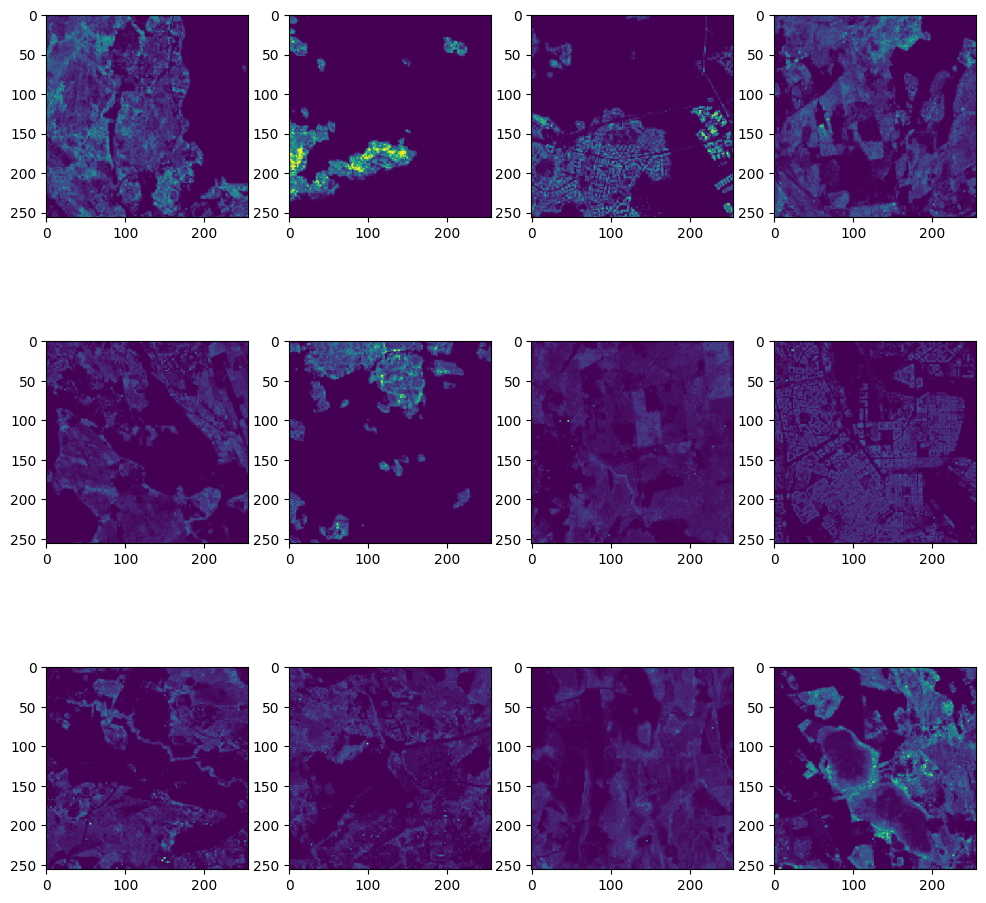

In [546]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,12))
axes = axes.flatten()
for ax, y in zip(axes, y_list[:12]):
    print(y.shape, y.max(), y.min(), y.mean())
    y = np.clip(y, a_min=0, a_max=y.mean()*20)
    ax.imshow(y)

In [7]:
month = 4
satellite = 1
def get_satellite_index(month, satellite):
    if satellite == 1:
        idxs = list(range((month-1)*4, month*4))
    elif satellite == 2:
        idxs = list(range(48+(month-1)*11, 48+month*11))
    return idxs

for month in [2,5,8]:
    idxs = get_satellite_index(month, satellite=1)
    yy = np.stack([data['X'][:,:,idxs] for data in dd.images])
    mean = np.mean(yy, axis=(0,1,2))
    std = np.std(yy, axis=(0,1,2))
    print(month, yy.shape)
    print('mean:', tuple(mean))
    print('std:', tuple(std))

2 (200, 256, 256, 4)
mean: (-12.002319, -19.420351, -11.224606, -18.09323)
std: (3.7635283, 4.2995796, 4.8440766, 6.63494)
5 (200, 256, 256, 4)
mean: (-11.454462, -18.02264, -11.284401, -17.548016)
std: (4.1526847, 5.0147295, 4.692451, 6.0603037)
8 (200, 256, 256, 4)
mean: (-11.459677, -17.916645, -11.043767, -17.12541)
std: (4.034115, 4.8394675, 4.645598, 5.9062114)


array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)

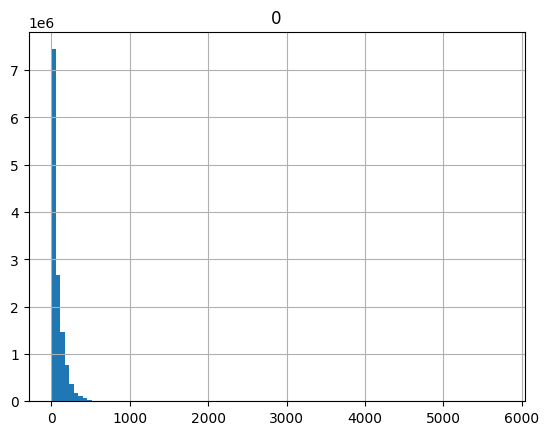

In [26]:
y_list = [data['y'] for data in dd.images]
y_flat = np.concatenate(y_list).flatten()
# y_flat = np.log(y_flat+1)/4.6
df = pd.DataFrame(y_flat)
df.hist(bins=100)

In [26]:
%cd /Users/loaner/projects/dd-biomassters

/Users/loaner/projects/dd-biomassters


## Test via command line interface

## Train dev

In [21]:
%cd /Users/loaner/projects/dd-biomassters
!python ./pix2pix/train.py \
    --dataroot ./data --name biomassters_20221202 --model pix2pix_bio --phase train --gpu_ids -1 \
    --direction AtoB --input_nc 16 --output_nc 1 --dataset_mode biomassters --preprocess "" --no_flip  \
    --g_activation Softplus \
    --batch_size 10 --max_dataset_size 100 \
    --n_epochs 40 --n_epochs_decay 5 --lr 0.0002 \
    --display_id 1 --display_freq 100 --print_freq 100 --update_html_freq 500 --save_epoch_freq 10 \

/Users/loaner/projects/dd-biomassters
----------------- Options ---------------
               batch_size: 10                            	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./data                        	[default: data]
             dataset_mode: biomassters                   	[default: aligned]
                direction: AtoB                          
              display_env: main                          
             display_freq: 100                           	[default: 400]
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256               

63d80a6c (256, 256, 16)
479938e1 (256, 256, 16)
3411cc89 (256, 256, 16)
23159416 (256, 256, 16)
9dfc6558 (256, 256, 16)
3f639fed (256, 256, 16)
dcfb6072 (256, 256, 16)
3abcf82c (256, 256, 16)
c850f570 (256, 256, 16)
36bb6861 (256, 256, 16)
f016331a (256, 256, 16)
b2c401d0 (256, 256, 16)
eb4f944d (256, 256, 16)
51e245a8 (256, 256, 16)
9353eb6d (256, 256, 16)
5957a5cc (256, 256, 16)
74cbb1e1 (256, 256, 16)
a5289942 (256, 256, 16)
799941cb (256, 256, 16)
a072b45b (256, 256, 16)
b3b09e5f (256, 256, 16)
35e67e33 (256, 256, 16)
42b5ac06 (256, 256, 16)
a259bbd9 (256, 256, 16)
7164a926 (256, 256, 16)
ef683082 (256, 256, 16)
0636b264 (256, 256, 16)
5209306d (256, 256, 16)
0ad475a1 (256, 256, 16)
874dde20 (256, 256, 16)
70dbbfd2 (256, 256, 16)
ab8aca7a (256, 256, 16)
1d98f768 (256, 256, 16)
04b380c7 (256, 256, 16)
f5279346 (256, 256, 16)
e3a3dba4 (256, 256, 16)
fb48851a (256, 256, 16)
91f65529 (256, 256, 16)
4c268cf7 (256, 256, 16)
3e398cfe (256, 256, 16)
e23ad4d7 (256, 256, 16)
d56a14ed (256, 2

04debe47 (256, 256, 16)
c6a1a0d1 (256, 256, 16)
7af9ab75 (256, 256, 16)
eb4f944d (256, 256, 16)
9353eb6d (256, 256, 16)
3f639fed (256, 256, 16)
0ad475a1 (256, 256, 16)
0636b264 (256, 256, 16)
e98df0c5 (256, 256, 16)
5957a5cc (256, 256, 16)
d8ae34f2 (256, 256, 16)
f5d934ef (256, 256, 16)
ef957a4d (256, 256, 16)
e23ad4d7 (256, 256, 16)
9dfc6558 (256, 256, 16)
baacf334 (256, 256, 16)
14888ef2 (256, 256, 16)
4618c2da (256, 256, 16)
04b380c7 (256, 256, 16)
4c268cf7 (256, 256, 16)
a01646fd (256, 256, 16)
a072b45b (256, 256, 16)
1d98f768 (256, 256, 16)
30fcd658 (256, 256, 16)
76e4ec0c (256, 256, 16)
3e4eba43 (256, 256, 16)
874dde20 (256, 256, 16)
dbe9a663 (256, 256, 16)
ab8aca7a (256, 256, 16)
8dbdd885 (256, 256, 16)
b2c401d0 (256, 256, 16)
23159416 (256, 256, 16)
0baa5577 (256, 256, 16)
55a14920 (256, 256, 16)
4f349d09 (256, 256, 16)
f151753a (256, 256, 16)
3d92ead9 (256, 256, 16)
a5289942 (256, 256, 16)
c850f570 (256, 256, 16)
63d80a6c (256, 256, 16)
f707aaad (256, 256, 16)
5fe2bef0 (256, 2

RMSE real image; type: <class 'torch.Tensor'>, shape: torch.Size([10, 1, 256, 256]), max: 4283.12, min: 0.00, mean: 56.80, std: 83.69
(epoch: 7, iters: 100, time: 1.297, data: 12.796) G_GAN: 0.690 G_L1: 9.951 D_real: 0.700 D_fake: 0.692 RMSE: 63.748 
End of epoch 7 / 45 	 Time Taken: 164 sec
learning rate 0.0002000 -> 0.0002000
5957a5cc (256, 256, 16)
51d93376 (256, 256, 16)
14888ef2 (256, 256, 16)
f822769e (256, 256, 16)
0d820bc7 (256, 256, 16)
cafffd1d (256, 256, 16)
3f639fed (256, 256, 16)
3abc0182 (256, 256, 16)
874dde20 (256, 256, 16)
28e70767 (256, 256, 16)
d7a3a181 (256, 256, 16)
25fd4e5d (256, 256, 16)
7c768708 (256, 256, 16)
5fe2bef0 (256, 256, 16)
51e245a8 (256, 256, 16)
dbe9a663 (256, 256, 16)
ef683082 (256, 256, 16)
14d3b92b (256, 256, 16)
3411cc89 (256, 256, 16)
a759e918 (256, 256, 16)
d56a14ed (256, 256, 16)
fb48851a (256, 256, 16)
f016331a (256, 256, 16)
3abcf82c (256, 256, 16)
b2c401d0 (256, 256, 16)
3f56d3a1 (256, 256, 16)
ef699037 (256, 256, 16)
55a14920 (256, 256, 16

893c3cd5 (256, 256, 16)
76e4ec0c (256, 256, 16)
75e80cb9 (256, 256, 16)
f5279346 (256, 256, 16)
0636b264 (256, 256, 16)
fb48851a (256, 256, 16)
0baa5577 (256, 256, 16)
3f639fed (256, 256, 16)
cafffd1d (256, 256, 16)
5a1bc9dd (256, 256, 16)
3e398cfe (256, 256, 16)
RMSE fake image; type: <class 'torch.Tensor'>, shape: torch.Size([10, 1, 256, 256]), max: 230.59, min: 0.63, mean: 80.23, std: 48.98
RMSE real image; type: <class 'torch.Tensor'>, shape: torch.Size([10, 1, 256, 256]), max: 4718.91, min: 0.00, mean: 72.37, std: 91.96
(epoch: 10, iters: 100, time: 1.337, data: 14.293) G_GAN: 0.703 G_L1: 13.261 D_real: 0.701 D_fake: 0.692 RMSE: 76.475 
saving the model at the end of epoch 10, iters 1000
End of epoch 10 / 45 	 Time Taken: 168 sec
learning rate 0.0002000 -> 0.0002000
cafffd1d (256, 256, 16)
76e4ec0c (256, 256, 16)
3abc0182 (256, 256, 16)
3411cc89 (256, 256, 16)
51d93376 (256, 256, 16)
04b380c7 (256, 256, 16)
584e3e68 (256, 256, 16)
7c768708 (256, 256, 16)
e98df0c5 (256, 256, 16)
b3

End of epoch 21 / 45 	 Time Taken: 165 sec
learning rate 0.0002000 -> 0.0002000
RMSE fake image; type: <class 'torch.Tensor'>, shape: torch.Size([10, 1, 256, 256]), max: 410.65, min: 0.04, mean: 54.65, std: 51.14
RMSE real image; type: <class 'torch.Tensor'>, shape: torch.Size([10, 1, 256, 256]), max: 4687.57, min: 0.00, mean: 70.10, std: 89.28
(epoch: 22, iters: 100, time: 1.308, data: 10.994) G_GAN: 0.702 G_L1: 9.386 D_real: 0.698 D_fake: 0.689 RMSE: 66.096 
End of epoch 22 / 45 	 Time Taken: 159 sec
learning rate 0.0002000 -> 0.0002000
RMSE fake image; type: <class 'torch.Tensor'>, shape: torch.Size([10, 1, 256, 256]), max: 356.58, min: 0.10, mean: 57.16, std: 49.52
RMSE real image; type: <class 'torch.Tensor'>, shape: torch.Size([10, 1, 256, 256]), max: 2407.02, min: 0.00, mean: 78.72, std: 90.37
(epoch: 23, iters: 100, time: 1.299, data: 10.191) G_GAN: 0.694 G_L1: 9.856 D_real: 0.698 D_fake: 0.693 RMSE: 67.855 
End of epoch 23 / 45 	 Time Taken: 163 sec
learning rate 0.0002000 -> 

End of epoch 39 / 45 	 Time Taken: 160 sec
learning rate 0.0002000 -> 0.0001667
RMSE fake image; type: <class 'torch.Tensor'>, shape: torch.Size([10, 1, 256, 256]), max: 489.10, min: 0.03, mean: 63.22, std: 69.24
RMSE real image; type: <class 'torch.Tensor'>, shape: torch.Size([10, 1, 256, 256]), max: 2738.34, min: 0.00, mean: 70.79, std: 90.01
(epoch: 40, iters: 100, time: 1.322, data: 13.190) G_GAN: 0.706 G_L1: 6.845 D_real: 0.722 D_fake: 0.666 RMSE: 49.706 
saving the model at the end of epoch 40, iters 4000
End of epoch 40 / 45 	 Time Taken: 167 sec
learning rate 0.0001667 -> 0.0001333
RMSE fake image; type: <class 'torch.Tensor'>, shape: torch.Size([10, 1, 256, 256]), max: 540.70, min: 0.01, mean: 72.03, std: 73.84
RMSE real image; type: <class 'torch.Tensor'>, shape: torch.Size([10, 1, 256, 256]), max: 3440.63, min: 0.00, mean: 67.95, std: 79.23
(epoch: 41, iters: 100, time: 1.308, data: 10.802) G_GAN: 0.699 G_L1: 6.852 D_real: 0.698 D_fake: 0.692 RMSE: 46.951 
End of epoch 41 / 

In [25]:
!python ./pix2pix/test.py --dataroot ./data --name biomassters_20221202 --model pix2pix_bio --direction AtoB \
    --input_nc 16 --output_nc 1 --dataset_mode biomassters --gpu_ids -1 --phase validation \
    --max_dataset_size 10 --preprocess "" \
    --eval --no_dropout --g_activation Softplus \
    --results_dir ./results/ \

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./data                        	[default: data]
             dataset_mode: biomassters                   	[default: aligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
             g_activation: Softplus                      	[default: Tanh]
                  gpu_ids: -1                            	[default: 0]
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 16                            	[defaul

## Scrap

In [557]:
model.netG

NameError: name 'model' is not defined

In [75]:
for name, param in model.netG.named_parameters():
    
    print(name, '\n', param.shape, type(param.data), param.data.mean().numpy(), param.data.min().numpy(),param.data.max().numpy())

model.model.0.weight 
 torch.Size([64, 180, 4, 4]) <class 'torch.Tensor'> -5.0240527e-05 -0.08555504 0.08721618
model.model.1.model.1.weight 
 torch.Size([128, 64, 4, 4]) <class 'torch.Tensor'> -0.000101658414 -0.083866164 0.09596747
model.model.1.model.2.weight 
 torch.Size([128]) <class 'torch.Tensor'> 0.99765587 0.95133114 1.0484908
model.model.1.model.2.bias 
 torch.Size([128]) <class 'torch.Tensor'> 2.6668804e-05 -0.0026267983 0.0031639268
model.model.1.model.3.model.1.weight 
 torch.Size([256, 128, 4, 4]) <class 'torch.Tensor'> 2.077245e-06 -0.0966072 0.09582907
model.model.1.model.3.model.2.weight 
 torch.Size([256]) <class 'torch.Tensor'> 0.99932534 0.9414475 1.0576552
model.model.1.model.3.model.2.bias 
 torch.Size([256]) <class 'torch.Tensor'> -8.123938e-05 -0.003666533 0.0035154072
model.model.1.model.3.model.3.model.1.weight 
 torch.Size([512, 256, 4, 4]) <class 'torch.Tensor'> -1.0472222e-05 -0.0980717 0.10492932
model.model.1.model.3.model.3.model.2.weight 
 torch.Size([5

## Check for missing data

In [114]:
import pandas as pd
df_metadata = pd.read_csv("data/metadata/features_metadata_split_42.csv",index_col=0)
df_metadata.head()

,chip_id,satellite,month,filename,split,size,cksum,s3path_us,s3path_eu,s3path_as,corresponding_agbm,file_not_found,num_s1_missing,num_s2_obscured
0,0003d2eb,S1,1,0003d2eb_S1_04.tif,validation,1049524.0,2.467836e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif,NaN,0.0,NaN
1,0003d2eb,S1,2,0003d2eb_S1_05.tif,validation,1049524.0,2.955838e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif,NaN,0.0,NaN
2,0003d2eb,S1,3,0003d2eb_S1_06.tif,validation,1049524.0,9.389132e+08,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif,NaN,0.0,NaN
3,0003d2eb,S1,4,0003d2eb_S1_07.tif,validation,1049524.0,2.259649e+08,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif,NaN,0.0,NaN
4,0003d2eb,S1,5,0003d2eb_S1_08.tif,validation,1049524.0,1.351820e+08,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif,NaN,0.0,NaN


In [115]:
df = df_metadata.copy()
df['satellite_month'] = df.apply(lambda row: f"{row['satellite']}_{row['month']}", axis=1)
df = df.groupby(['split', 'chip_id']).agg({"satellite_month": pd.Series.nunique, "num_s1_missing": sum, "num_s2_obscured": sum}).reset_index()

In [119]:
for split in ('train', 'validation', 'test'):
    print(f'Total {split}', len(df[(df.split==split)]))
    print(f'# with all satellite and monthly data', len(df[(df.split==split)&(df.satellite_month==24)]))
    print(f'# with no S1 missing pixels', len(df[(df.split==split)&(df.num_s1_missing==0)]))
    print(f'# with no S2 obscured pixels', len(df[(df.split==split)&(df.num_s2_obscured==0)]))
    print(f'# complete',len(df[(df.split==split)&(df.satellite_month==24)&(df.num_s1_missing==0)&(df.num_s2_obscured==0)]))

Total train 5821
# with all satellite and monthly data 831
# with no S1 missing pixels 4618
# with no S2 obscured pixels 5821
# complete 339
Total validation 2868
# with all satellite and monthly data 2868
# with no S1 missing pixels 2280
# with no S2 obscured pixels 2868
# complete 2280
Total test 2773
# with all satellite and monthly data 539
# with no S1 missing pixels 2121
# with no S2 obscured pixels 2773
# complete 207


In [133]:
complete_chips = df[(df.split==split)&(df.satellite_month==24)&(df.num_s1_missing==0)&(df.num_s2_obscured==0)].chip_id.to_list()
df_metadata['is_complete'] = df_metadata.chip_id.isin(complete_chips)

In [137]:
df_metadata[df_metadata.chip_id == '025109d9']

,chip_id,satellite,month,filename,split,size,cksum,s3path_us,s3path_eu,s3path_as,corresponding_agbm,file_not_found,num_s1_missing,num_s2_obscured,is_complete
2400,025109d9,S1,1,025109d9_S1_04.tif,test,1049524.0,1.348541e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2401,025109d9,S1,2,025109d9_S1_05.tif,test,1049524.0,2.937115e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2402,025109d9,S1,3,025109d9_S1_06.tif,test,1049524.0,3.755354e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2403,025109d9,S1,4,025109d9_S1_07.tif,test,1049524.0,2.547600e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2404,025109d9,S1,5,025109d9_S1_08.tif,test,1049524.0,4.067836e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2405,025109d9,S1,6,025109d9_S1_09.tif,test,1049524.0,3.783115e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2406,025109d9,S1,7,025109d9_S1_10.tif,test,1049524.0,8.027817e+08,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2407,025109d9,S1,8,025109d9_S1_11.tif,test,1049524.0,3.990932e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2408,025109d9,S1,9,025109d9_S1_00.tif,test,1049524.0,1.624165e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2409,025109d9,S1,10,025109d9_S1_01.tif,test,1049524.0,4.187200e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True


In [428]:
f = nn.Sigmoid()
nn.Sigmoid

torch.nn.modules.activation.Sigmoid

In [427]:
getattr(globals()['nn'], 'Sigmoid')

torch.nn.modules.activation.Sigmoid

In [429]:
f = getattr(globals()['nn'], 'Sigmoid')()
input = torch.randn(2)
f(input)

tensor([0.6459, 0.7864])

In [437]:
def get_activation_layer(activation):
    if not activation:
        return None
    if activation in torch.nn.modules.activation.__all__:
        return getattr(globals()['nn'], activation)()
    else:
        raise ValueError(f'Activation {activation} not recognized')
        
f = get_activation_layer('relu')
f, f(input)

ValueError: Activation relu not recognized

In [464]:
def _get_chip_metadata(metadata, chip_id):
    return metadata[(metadata.chip_id==chip_id) & (metadata.satellite=='S1')]

def _load_chip_feature_data_by_quarter(metadata, chip_id):
    metadata = _get_chip_metadata(metadata, chip_id)
    img_quarter_list = []
    for Q in range(1,5):
        print('Quarter', Q)
        # get images in quarter
        img_month_list = []
        for _, row in metadata[metadata.Q==Q].iterrows():
            print('month', row.month)
            s3_key = f"train_features/{row.filename}"
            #img = load_tif(out_path=f'data/{s3_key}')
            img = tif.imread(f'data/{s3_key}')
            print('monthly image', img.shape)
            img_month_list.append(img)
        # average over images per channel
        channel_list = []
        for ch in range(img.shape[2]):
            print('channel', ch)
            x = np.nanmean([x[:,:,ch] for x in img_month_list], axis=0)
            print(x.shape)
            channel_list.append(x)
        x = np.stack(channel_list, axis=2)
        print('concat', x.shape)
        
        img_quarter_list.append(x)
    return np.concatenate(img_quarter_list, axis=2)


0.79

In [ ]:
x = _load_chip_feature_data_by_quarter(df_metadata_complete, '0003d2eb')